# Base methods to deal with the test cases

In [111]:
import matplotlib.pyplot as plt  
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
sns.set(font_scale=1.5)

### Base methods to deal with preprocessing data
- **fill_gaps** : *Method that deals with missing data from a dataframe*
- **normalize** : *Method that normalize data rescaling numerical values to a predefined range*
- **pca** : *Method that applies Principal Component Analysis (PCA) in a dataframe*

To deal with missing values in the dataset, we opt to fill them out using the most frequent value in each column.
Regarding the data normalization, we apply a function that scales each integer attribute to a range of [0, 1].
In the test cases that use dimensionality reduction, we apply PCA in all of the 170 attributes, reducing to 70.

In [112]:
def fill_gaps(df, empty_token = '?'):
    imputer = SimpleImputer(missing_values = empty_token, strategy = 'most_frequent')
    result = imputer.fit_transform(df)
    
    result_df = DataFrame(result)
    result_df.columns = df.columns
    result_df.index = df.index
    return result_df


def normalize(df, columns, range=(0,1)):
    scaler = MinMaxScaler(feature_range=range)
    for col in columns:
        scaled_values = scaler.fit_transform(df[[col]].values.astype(float))
        df[col] = scaled_values
    return df


def pca(train_df, test_df, components = 32):
    pca = PCA(n_components = components)
    pca.fit(train_df)
    train_pca = pca.transform(train_df)
    test_pca = pca.transform(test_df)
    component_cols = []
    for i in range(0, components):
        component_cols.append('component_%s'%i)
        
    pca_train_df = DataFrame(data = train_pca, columns = component_cols)
    pca_test_df = DataFrame(data = test_pca, columns = component_cols)
    return pca_train_df, pca_test_df


def cost(fp, fn):
    return (fp * 10) + (fn * 500)


def train_classifier(pre_train_df, pre_test_df):
    x_train = pre_train_df.iloc[:, 1:].values
    y_train = pre_train_df['class'].values

    x_test = pre_test_df.iloc[:, 1:].values
    y_test = pre_test_df['class'].values

    t1_classifier = DecisionTreeClassifier()
    t1_classifier.fit(x_train, y_train)

    y_pred = t1_classifier.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    display("Accuracy %s" % (accuracy))

    matrix = confusion_matrix(y_pred, y_test)
    tn, fp, fn, tp = matrix.ravel()
    display ("False positives: %s - False Negatives %s" % (fp, fn))
    display("Cost: %s" % (cost(fp, fn)))

    figure = sns.heatmap(matrix, annot=True, fmt="d", cbar=False)
    figure.set(xlabel='Predicted', ylabel='Actual')
    figure.get_figure().savefig('matrix_classifier.pdf')

    
def train_clustering(pre_train_df, pre_test_df):
    x_train = pre_train_df.iloc[:, 1:].values
    # y_train = pre_train_df['class'].values

    x_test = pre_test_df.iloc[:, 1:].values
    y_test = pre_test_df['class'].values
    
    kmeans = KMeans(n_clusters=2)  
    kmeans.fit(x_train)

    # display("Clusters labels: %s" % (kmeans.labels_))
    # display("Clusters centers: %s" % (kmeans.cluster_centers_))
    plt.scatter(x_train[:,0],x_train[:,1], c=kmeans.labels_, cmap='rainbow')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'green', label = 'Centroids')
    plt.savefig('cluster.pdf')
    plt.show()
    
    
    y_pred = kmeans.predict(x_test)
    y_pred = np.where(y_pred > 0, 'pos', 'neg')

    accuracy = accuracy_score(y_test, y_pred)
    display("Accuracy %s" % (accuracy))
    
    matrix = confusion_matrix(y_pred, y_test)
    tn, fp, fn, tp = matrix.ravel()
    display ("False positives: %s - False Negatives %s" % (fp, fn))
    display("Cost: %s" % (cost(fp, fn)))
    
    figure = sns.heatmap(matrix, annot=True, fmt="d", cbar=False);
    figure.set(xlabel='Predicted', ylabel='Actual')
    figure.get_figure().savefig('matrix_cluster.pdf')
    

# Load the train and test datasets

In [113]:
train_df = pd.read_csv("aps_training_set_sample3.csv", low_memory=False)
test_df = pd.read_csv("aps_failure_test_set.csv", low_memory=False)

# Balancing classes in train dataset

We noted that this dataset contains a disproportionate ratio of instances for each class, which may result in a bias to the majority class. The majority class contains 1091 more instances than the minority class. In order to balance the dataset regarding the number of instances per classes, we remove elements applying *downsampling* in the majority class to balance the dataset.

neg    2091
pos    1000
Name: class, dtype: int64

pandas.core.series.Series

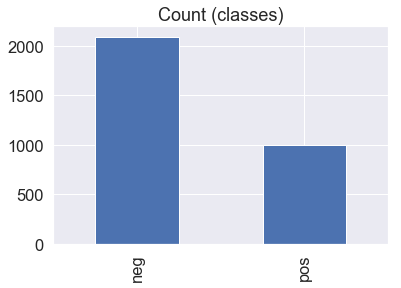

In [114]:
classes = train_df['class'].value_counts()
display(classes)
display(type(classes))
classes.plot(kind='bar', title='Count (classes)')

'Positive samples: 1000 - Negative samples: 2091'

'Using 1000 samples per class'

neg    1000
pos    1000
Name: class, dtype: int64

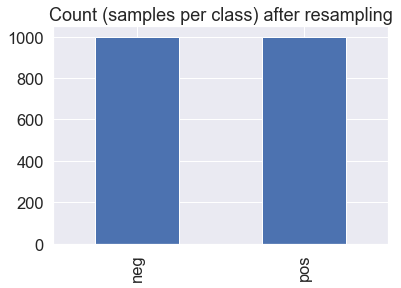

In [115]:
# we need to balance the classes 
positive_class = train_df[train_df['class'] == 'pos']
qtd_pos = positive_class.shape[0]
negative_class = train_df[train_df['class'] == 'neg']
qtd_neg = negative_class.shape[0]

display("Positive samples: %s - Negative samples: %s" % (qtd_pos, qtd_neg))
new_samples = min(qtd_neg, qtd_pos)
display("Using %s samples per class" % (new_samples))

balanced_train_df = shuffle(pd.concat([positive_class[:new_samples], negative_class[:new_samples]], ignore_index = True))
balanced_classes = balanced_train_df['class'].value_counts()

display(balanced_classes)
display(balanced_classes.plot(kind='bar', title='Count (samples per class) after resampling'))

# Test Case 1
- fill_gaps
- using kmeans from sklearn

In this test case, we simply input the missing values and applies a classifier (Decision Tree and k-menas for *class to cluster evaluation*). 
We noted that, although our trained classifier results in a high accuracy in test set, the number of high false negatives generated a high cost.

'Accuracy 0.9268125'

'False positives: 17 - False Negatives 1154'

'Cost: 577170'

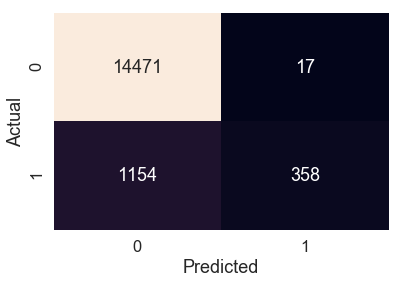

In [122]:
pre_train_df = fill_gaps(balanced_train_df)
pre_test_df = fill_gaps(test_df)

train_classifier(pre_train_df, pre_test_df)

## Cluster to class evaluation of test case **1**

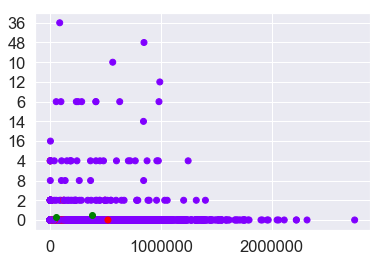

'Accuracy 0.8185'

'False positives: 373 - False Negatives 2531'

'Cost: 1269230'

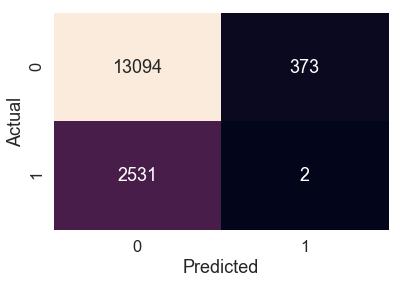

In [123]:
train_clustering(pre_train_df, pre_test_df)

# Test Case 2
In this test case, we introduce normalized data to the classifiers in order to decrease the variance of the values.
We noted in this case that normalization 

'Accuracy 0.9391875'

'False positives: 131 - False Negatives 842'

'Cost: 422310'

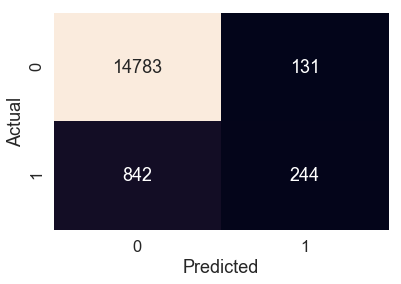

In [124]:
norm_train_df = normalize(pre_train_df, columns = pre_train_df.columns[1:]) # ignore label
norm_test_df = normalize(pre_test_df, columns = pre_test_df.columns[1:]) # ignore label

train_classifier(norm_train_df, norm_test_df)

## Cluster to class evaluation of test case **2**

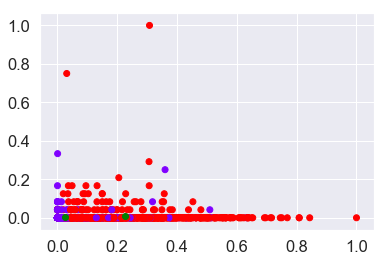

'Accuracy 0.8795625'

'False positives: 27 - False Negatives 1900'

'Cost: 950270'

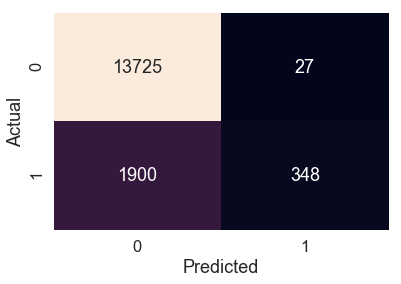

In [125]:
train_clustering(norm_train_df, norm_test_df)

# Test Case 3
- dimensionality reduction through pca

'Accuracy 0.5066875'

'False positives: 170 - False Negatives 7723'

'Cost: 3863200'

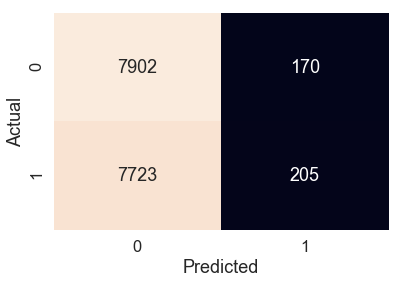

In [126]:
filtered_train_df = norm_train_df.loc[:, norm_train_df.columns != 'class']
filtered_test_df = norm_test_df.loc[:, norm_train_df.columns != 'class']

pca_train_df, pca_test_df = pca(filtered_train_df, filtered_test_df)

pca_train_df = pd.concat([pre_train_df['class'], pca_train_df], axis=1)
pca_test_df = pd.concat([pre_test_df['class'], pca_test_df], axis = 1)

train_classifier(pca_train_df, pca_test_df)

## Cluster to class evaluation of test case **3**

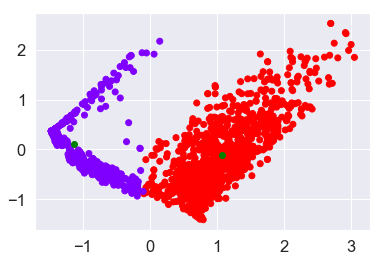

'Accuracy 0.8795625'

'False positives: 27 - False Negatives 1900'

'Cost: 950270'

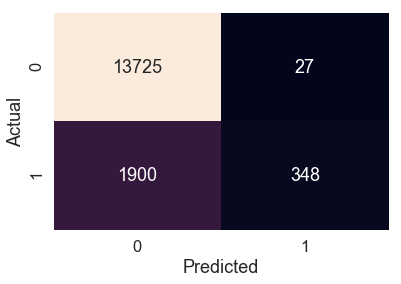

In [129]:
train_clustering(pca_train_df, pca_test_df)